In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from MCForecastTools import MCSimulation
import openai


%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
# # Set current amount of shares
# my_jpm = 50
# my_jnj = 50
# my_msft = 50
# my_rio = 50
# my_pfe = 50

In [4]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [5]:
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [8]:
initial_investment = input('Please type in the total initial investment: $')

stock_name1 = input('Please choose the stock you want to invest: JPM, JNJ, MSFT, RIO, PFE?')# Set weights
stock1_weight = input(f"Please type in the weight to invest {stock_name1}")

stock_name2 = input('Please choose the second stock you want to invest: JPM, JNJ, MSFT, RIO, PFE? ')
stock2_weight = input(f"Please type in the weight to invest {stock_name2}")

stock_name3 = input('Please choose the second stock you want to invest: JPM, JNJ, MSFT, RIO, PFE? ')
stock3_weight = input(f"Please type in the weight to invest {stock_name3}")

stock1_weight = float(stock1_weight)
stock2_weight = float(stock2_weight)
stock3_weight = float(stock3_weight)

weights = [stock1_weight, stock2_weight, stock3_weight]
initial_investment = int(initial_investment)

Please type in the total initial investment: $ 10000
Please choose the stock you want to invest: JPM, JNJ, MSFT, RIO, PFE? JPM
Please type in the weight to invest JPM 0.3
Please choose the second stock you want to invest: JPM, JNJ, MSFT, RIO, PFE?  PFE
Please type in the weight to invest PFE 0.5
Please choose the second stock you want to invest: JPM, JNJ, MSFT, RIO, PFE?  MSFT
Please type in the weight to invest MSFT 0.2


In [9]:
# Format todays date as ISO format
start_date = pd.Timestamp("2018-05-07", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-05-07", tz="America/New_York").isoformat()

# Set the tickers
tickers = [stock_name1, stock_name2, stock_name3, 'SPY']

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices
df_portfolio = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

In [10]:
# Reorganize the DataFrame
# Separate ticker data
# JPM = df_portfolio[df_portfolio['symbol']=='JPM'].drop('symbol', axis=1)
# JNJ = df_portfolio[df_portfolio['symbol']=='JNJ'].drop('symbol', axis=1)
# MSFT = df_portfolio[df_portfolio['symbol']=='MSFT'].drop('symbol', axis=1)
# RIO = df_portfolio[df_portfolio['symbol']=='RIO'].drop('symbol', axis=1)
# PFE = df_portfolio[df_portfolio['symbol']=='PFE'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)
stock1 = df_portfolio[df_portfolio['symbol']== stock_name1].drop('symbol', axis=1)
stock2 = df_portfolio[df_portfolio['symbol']== stock_name2].drop('symbol', axis=1)
stock3 = df_portfolio[df_portfolio['symbol']== stock_name3].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_combined = pd.concat([stock1,stock2,stock3,SPY], axis=1, keys=[stock_name1,stock_name2,stock_name3,'SPY'])
df_combined

JPM                                       \
                             open      high      low   close    volume   
timestamp                                                                
2018-05-07 04:00:00+00:00  108.76  109.6800  108.360  109.37   9360321   
2018-05-08 04:00:00+00:00  109.53  111.3400  109.280  110.99  12543451   
2018-05-09 04:00:00+00:00  111.44  113.6400  111.030  113.41  11368094   
2018-05-10 04:00:00+00:00  113.19  114.4400  112.750  114.29   9159723   
2018-05-11 04:00:00+00:00  114.49  114.7300  113.670  113.86  10253045   
...                           ...       ...      ...     ...       ...   
2023-05-01 04:00:00+00:00  142.26  143.3700  140.830  141.20  20422963   
2023-05-02 04:00:00+00:00  141.40  142.4100  138.430  138.92  14117994   
2023-05-03 04:00:00+00:00  138.44  138.6687  135.760  135.98  12937158   
2023-05-04 04:00:00+00:00  134.96  135.7200  131.810  134.12  17089164   
2023-05-05 04:00:00+00:00  136.44  137.8800  135.912  136.74  11106638   

                                                     PFE                 ...  \
                          trade_count        vwap   open    high    low  ...   
timestamp                                                                ...   
2018-05-07 04:00:00+00:00       63644  109.112860  34.79  35.130  34.71  ...   
2018-05-08 04:00:00+00:00       82974  110.634988  34.91  35.090  34.71  ...   
2018-05-09 04:00:00+00:00       77404  112.738976  35.02  35.405  34.87  ...   
2018-05-10 04:00:00+00:00       64923  113.926070  35.00  35.310  34.89  ...   
2018-05-11 04:00:00+00:00       66275  114.032989  35.13  35.560  35.07  ...   
...                               ...         ...    ...     ...    ...  ...   
2023-05-01 04:00:00+00:00      225315  141.925916  39.00  39.520  38.86  ...   
2023-05-02 04:00:00+00:00      178268  139.418115  39.29  40.115  38.63  ...   
2023-05-03 04:00:00+00:00      156409  137.014310  39.20  39.390  38.36  ...   
2023-05-04 04:00:00+00:00      204069  133.616646  38.17  38.430  38.02  ...   
2023-05-05 04:00:00+00:00      128401  136.707656  38.38  38.500  38.09  ...   

                               MSFT                             SPY           \
                             volume trade_count        vwap    open     high   
timestamp                                                                      
2018-05-07 04:00:00+00:00  24262669      172194   96.187561  266.89  268.020   
2018-05-08 04:00:00+00:00  23484705      158816   95.643806  266.50  267.325   
2018-05-09 04:00:00+00:00  27327610      159050   96.349569  267.68  269.865   
2018-05-10 04:00:00+00:00  22388119      130886   97.637509  270.34  272.390   
2018-05-11 04:00:00+00:00  16778316      110233   97.508981  272.16  273.150   
...                             ...         ...         ...     ...      ...   
2023-05-01 04:00:00+00:00  21329194      317112  306.613708  415.47  417.620   
2023-05-02 04:00:00+00:00  26403119      393404  306.093055  414.77  414.820   
2023-05-03 04:00:00+00:00  21652503      338579  305.760929  411.36  413.870   
2023-05-04 04:00:00+00:00  22519707      311223  305.777013  406.93  407.270   
2023-05-05 04:00:00+00:00  27513431      375141  309.594010  408.91  413.720   

                                                                               
                               low   close     volume trade_count        vwap  
timestamp                                                                      
2018-05-07 04:00:00+00:00  266.110  266.92   56495099      242699  267.100589  
2018-05-08 04:00:00+00:00  265.150  266.89   67703408      264713  266.430002  
2018-05-09 04:00:00+00:00  267.090  269.47   59773310      255999  268.713210  
2018-05-10 04:00:00+00:00  270.220  272.00   72065572      258139  271.419538  
2018-05-11 04:00:00+00:00  271.580  272.64   59909145      215034  272.463557  
...                            ...     ...        ...         ...         ...  
2023-05-01 04:00:00+00:00  415.

In [11]:
# Pick JPM, JNJ, MSFT, RIO, and PFE close prices
# jpm_close_price = df_combined["JPM"]["close"].values
# jnj_close_price = df_combined["JNJ"]["close"].values
# msft_close_price = df_combined["MSFT"]["close"].values
# rio_close_price = df_combined["RIO"]["close"].values
# pfe_close_price = df_combined["PFE"]["close"].values
spy_close_price = df_combined["SPY"]["close"].values[0]
stock1_close_price = df_combined[stock_name1]["close"].values[0]
stock2_close_price = df_combined[stock_name2]["close"].values[0]
stock3_close_price = df_combined[stock_name3]["close"].values[0]

In [12]:
# Print close prices
print(f"Current {stock_name1} closing price: ${stock1_close_price}")
print(f"Current {stock_name2} closing price: ${stock2_close_price}")
print(f"Current {stock_name3} closing price: ${stock3_close_price}")
# print(f"Current JNJ closing price: ${jnj_close_price}")
# print(f"Current MSFT closing price: ${msft_close_price}")
# print(f"Current RIO closing price: ${rio_close_price}")
# print(f"Current PFE closing price: ${pfe_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current JPM closing price: $109.37
Current PFE closing price: $34.93
Current MSFT closing price: $96.22
Current SPY closing price: $266.92


In [13]:
# Format start and end date as ISO format
# start_date = pd.Timestamp("2017-08-07", tz="America/New_York").isoformat()
# end_date = pd.Timestamp("2022-08-07", tz="America/New_York").isoformat()

In [14]:
# Get 5 years' worth of historical data 
# ticker_data = api.get_bars(
#     tickers,
#     timeframe,
#     start = start_date,
#     end = end_date
# ).df
# Reorganize the DataFrame
# Separate ticker data
# JPM_2 = ticker_data[ticker_data['symbol']=='JPM'].drop('symbol', axis=1)
# JNJ_2 = ticker_data[ticker_data['symbol']=='JNJ'].drop('symbol', axis=1)
# MSFT_2 = ticker_data[ticker_data['symbol']=='MSFT'].drop('symbol', axis=1)
# RIO_2 = ticker_data[ticker_data['symbol']=='RIO'].drop('symbol', axis=1)
# PFE_2 = ticker_data[ticker_data['symbol']=='PFE'].drop('symbol', axis=1)
# SPY_2 = ticker_data[ticker_data['symbol']=='SPY'].drop('symbol', axis=1)

# JPM_2 = JPM_2['close']
# JNJ_2 = JNJ_2['close']
# MSFT_2 = MSFT_2['close']
# RIO_2 = RIO_2['close']
# PFE_2 = PFE_2['close']
# SPY_2 = SPY_2['close']




In [15]:
# JPM_returns = JPM_2.pct_change().dropna().copy()
# JNJ_returns = JNJ_2.pct_change().dropna().copy()
# MSFT_returns = MSFT_2.pct_change().dropna().copy()
# RIO_returns = RIO_2.pct_change().dropna().copy()
# PFE_returns = PFE_2.pct_change().dropna().copy()
# SPY_returns = SPY_2.pct_change().dropna().copy()

In [16]:
# Concatenate the ticker DataFrames
df_stock_data = pd.concat([stock1['close'], stock2['close'], stock3['close'], SPY['close']], 
                          axis=1, keys=[stock_name1,stock_name2,stock_name3,'SPY'])

# Display sample data
df_stock_data.head()

,JPM,PFE,MSFT,SPY
timestamp,,,,
2018-05-07 04:00:00+00:00,109.37,34.93,96.22,266.92
2018-05-08 04:00:00+00:00,110.99,34.98,95.81,266.89
2018-05-09 04:00:00+00:00,113.41,35.17,96.94,269.47
2018-05-10 04:00:00+00:00,114.29,35.04,97.91,272.00
2018-05-11 04:00:00+00:00,113.86,35.50,97.70,272.64


In [17]:
print(df_stock_data.columns)

Index(['JPM', 'PFE', 'MSFT', 'SPY'], dtype='object')


In [18]:
# Calculate daily returns for all portfolios
daily_returns = df_stock_data.pct_change().dropna().copy()
# Calculate portfolio return
stock_daily_returns = daily_returns.drop('SPY', axis=1)
stock_daily_returns.head()
portfolio_return = stock_daily_returns.dot(weights)
# Display sample data
portfolio_return.head()

timestamp
2018-05-08 04:00:00+00:00    0.004307
2018-05-09 04:00:00+00:00    0.011616
2018-05-10 04:00:00+00:00    0.002481
2018-05-11 04:00:00+00:00    0.005006
2018-05-14 04:00:00+00:00    0.005851
dtype: float64

In [19]:
daily_returns["Custom Portfolio"] = portfolio_return
daily_returns.head()

,JPM,PFE,MSFT,SPY,Custom Portfolio
timestamp,,,,,
2018-05-08 04:00:00+00:00,0.014812,0.001431,-0.004261,-0.000112,0.004307
2018-05-09 04:00:00+00:00,0.021804,0.005432,0.011794,0.009667,0.011616
2018-05-10 04:00:00+00:00,0.007759,-0.003696,0.010006,0.009389,0.002481
2018-05-11 04:00:00+00:00,-0.003762,0.013128,-0.002145,0.002353,0.005006
2018-05-14 04:00:00+00:00,0.000351,0.010141,0.003378,0.001137,0.005851


<AxesSubplot:ylabel='Frequency'>

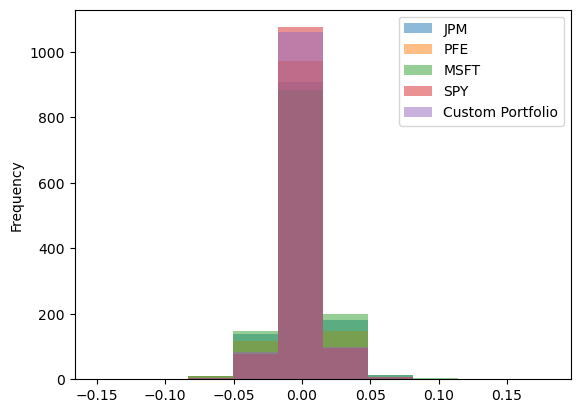

In [20]:
# Visualize the distribution of daily returns across all stocks using a histogram plot

daily_returns.plot.hist(alpha=0.5)

<AxesSubplot:ylabel='Density'>

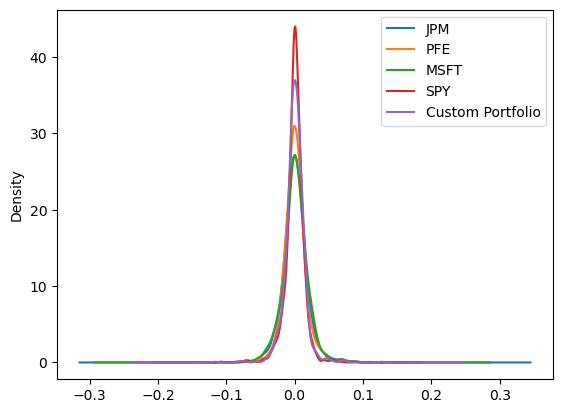

In [21]:
 # Visualize the distribution of daily returns across all stocks using a density plot
daily_returns.plot.density()

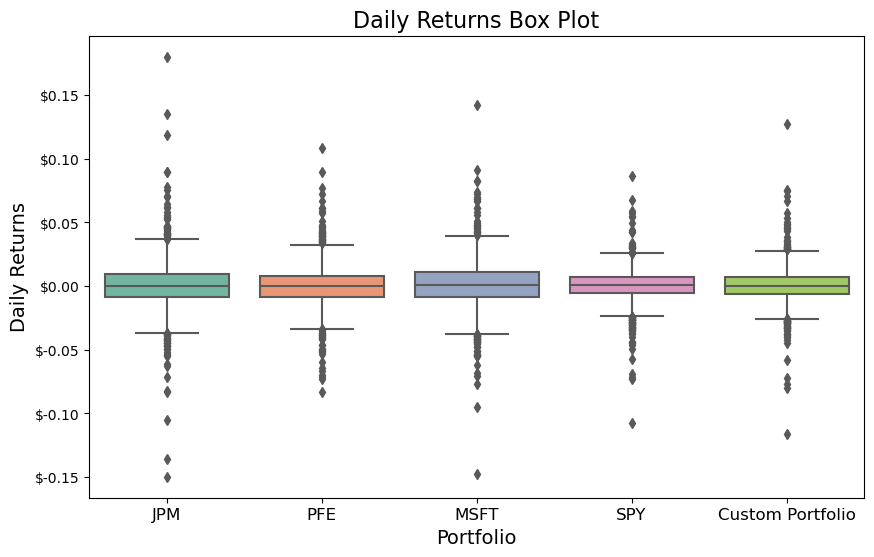

In [22]:
# Create box plot of daily returns for all portfolios

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=daily_returns, palette="Set2")
ax.set_title('Daily Returns Box Plot', fontsize=16)
ax.set_xlabel('Portfolio', fontsize=14)
ax.set_ylabel('Daily Returns', fontsize=14)

plt.xticks(fontsize=12)
ax.yaxis.set_major_formatter('${x:,.2f}')

# Show the plot
plt.show()

<AxesSubplot:title={'center':'Daily Returns'}, xlabel='timestamp'>

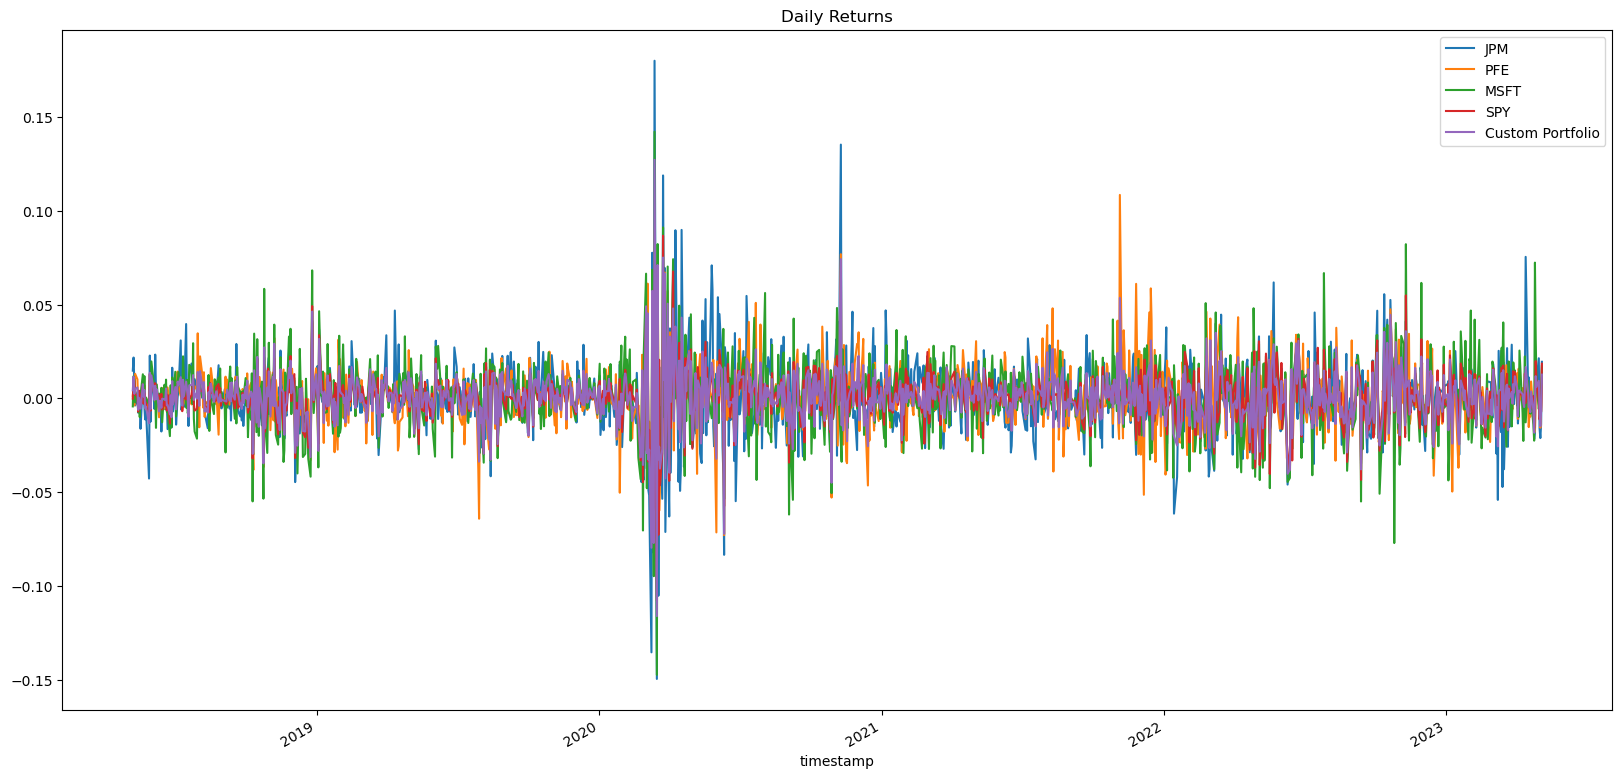

In [23]:
daily_returns.plot(figsize=(20, 10), title="Daily Returns")

In [24]:
# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod() - 1
cumulative_returns

,JPM,PFE,MSFT,SPY,Custom Portfolio
timestamp,,,,,
2018-05-08 04:00:00+00:00,0.014812,0.001431,-0.004261,-0.000112,0.004307
2018-05-09 04:00:00+00:00,0.036939,0.006871,0.007483,0.009553,0.015973
2018-05-10 04:00:00+00:00,0.044985,0.003149,0.017564,0.019032,0.018494
2018-05-11 04:00:00+00:00,0.041053,0.016318,0.015381,0.021430,0.023592
2018-05-14 04:00:00+00:00,0.041419,0.026625,0.018811,0.022591,0.029582
...,...,...,...,...,...
2023-05-01 04:00:00+00:00,0.291030,0.122531,2.175639,0.556684,0.564996
2023-05-02 04:00:00+00:00,0.270184,0.118236,2.174080,0.539188,0.554268
2023-05-03 04:00:00+00:00,0.243303,0.100773,2.163583,0.528623,0.531235


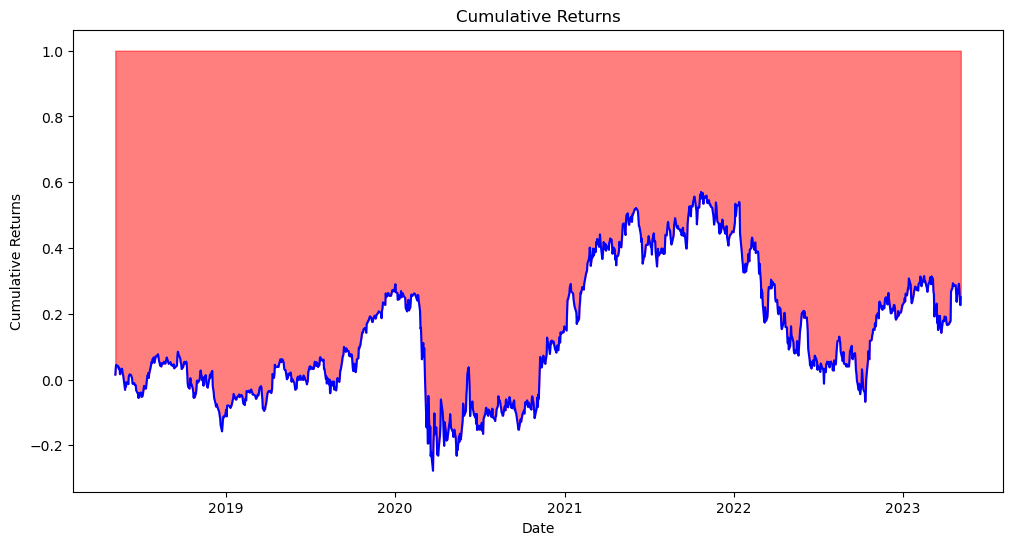

In [25]:
# plot cumulative returns
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cumulative_returns.iloc[:,0], color='blue')

# fill above and below 1
ax.fill_between(cumulative_returns.index, cumulative_returns.iloc[:,0], 1, where=cumulative_returns.iloc[:,0]>=1, interpolate=True, color='green', alpha=0.5)
ax.fill_between(cumulative_returns.index, cumulative_returns.iloc[:,0], 1, where=cumulative_returns.iloc[:,0]<=1, interpolate=True, color='red', alpha=0.5)

# set plot title and axis labels
ax.set_title('Cumulative Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# show plot
plt.show()

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='timestamp'>

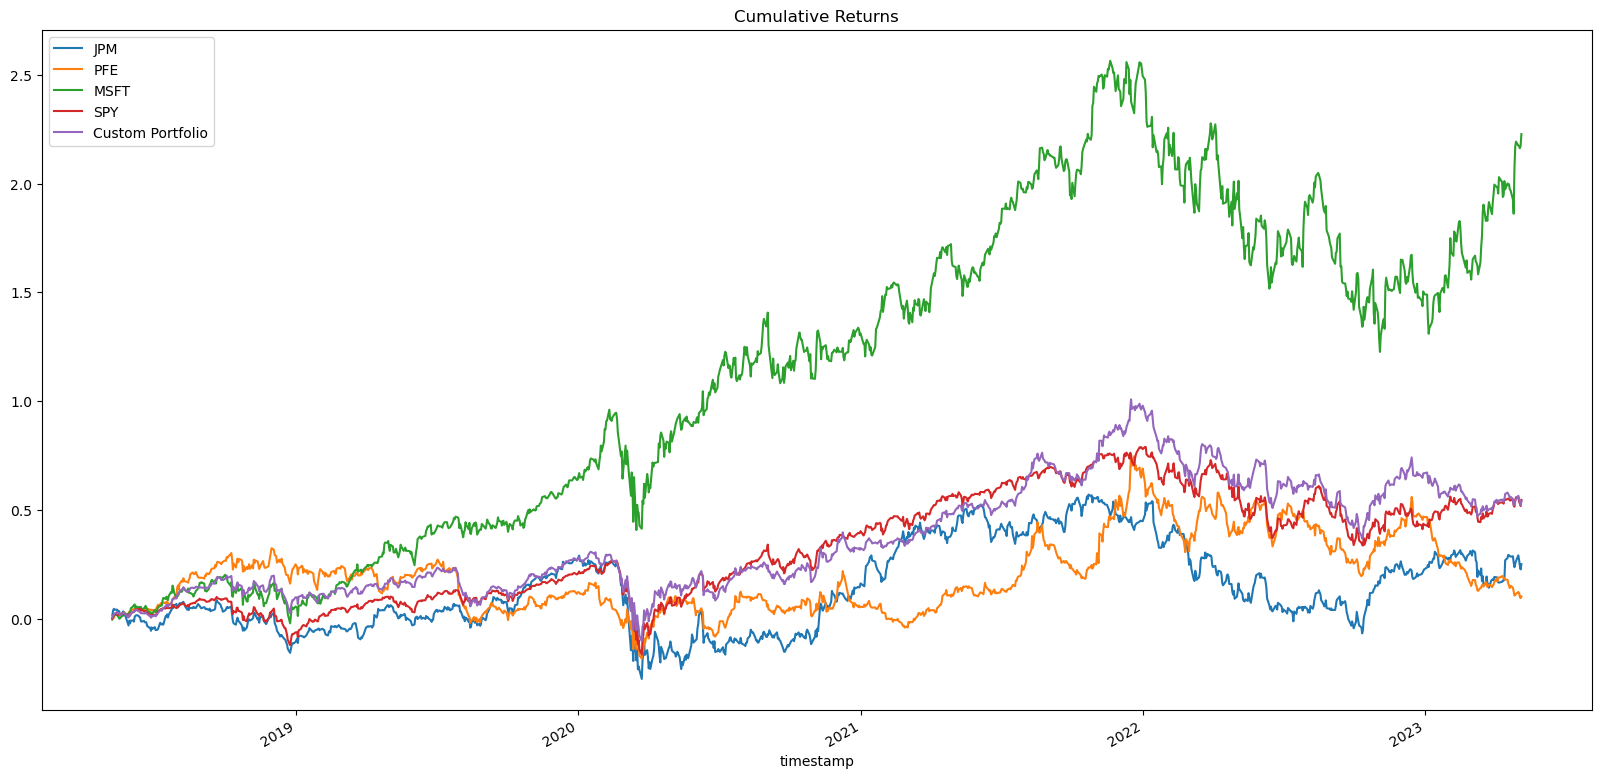

In [26]:
cumulative_returns.plot(figsize=(20, 10), title="Cumulative Returns")

In [28]:
# Calculate the daily standard deviations of all portfolios
daily_std = daily_returns.std()
stock1_std = daily_returns[stock_name1].std()
stock2_std = daily_returns[stock_name2].std()
stock3_std = daily_returns[stock_name3].std()
spy_stock = daily_returns['SPY'].std()
portfolio_std = daily_returns['Custom Portfolio'].std()
print("Daily Standard Deviation:")
print(daily_std)

# Calculate the annualised standard deviation 
annualised_std = daily_std * np.sqrt(252)
stock1_annualised_std = stock1_std * np.sqrt(252)
stock2_annualised_std = stock2_std * np.sqrt(252)
stock3_annualised_std = stock2_std * np.sqrt(252)
spy_annualised_std = spy_stock * np.sqrt(252)
portfolio_annualised_std = portfolio_std * np.sqrt(252)
print("Annualised Standard Deviation:")
print(annualised_std)


if stock1_annualised_std > spy_annualised_std and stock2_annualised_std > spy_annualised_std and stock3_annualised_std > spy_annualised_std:
    print("Based on the value of annualised standard deviations, all three stocks are riskier than the S&P 500 index.")
elif stock1_annualised_std > spy_annualised_std and stock2_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name1} and {stock_name2} are riskier than the S&P 500 index.")
elif stock1_annualised_std > spy_annualised_std and stock3_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name1} and {stock_name3} are riskier than the S&P 500 index.")
elif stock2_annualised_std > spy_annualised_std and stock3_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name2} and {stock_name3} are riskier than the S&P 500 index.")
elif stock1_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name1} is riskier than the S&P 500 index.")
elif stock2_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name2} is riskier than the S&P 500 index.")
elif stock3_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name3} is riskier than the S&P 500 index.")
else:
    print("Based on the value of annualised standard deviations, all three stocks are less risky than the S&P 500 index.")
    
if portfolio_annualised_std > spy_annualised_std:
    print("The custom portfolio is riskier than the market (SPY).")
else:
    print("The custom portfolio is less risky than the market (SPY).")

Daily Standard Deviation:
JPM                 0.020376
PFE                 0.016640
MSFT                0.019540
SPY                 0.013245
Custom Portfolio    0.014412
dtype: float64
Annualised Standard Deviation:
JPM                 0.323467
PFE                 0.264152
MSFT                0.310182
SPY                 0.210265
Custom Portfolio    0.228784
dtype: float64
Based on the value of annualised standard deviations, all three stocks are riskier than the S&P 500 index.
The custom portfolio is riskier than the market (SPY).


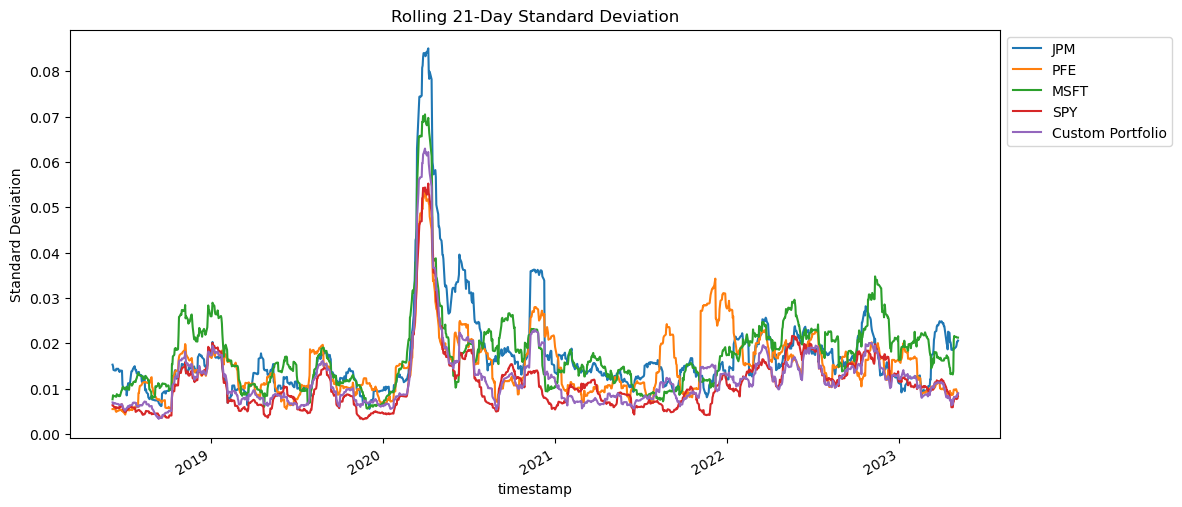

In [29]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
window_size = 21
rolling_std = daily_returns.rolling(window_size).std()

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Set title, x-label, y-label, and grid
ax.set_title('Rolling 21-Day Standard Deviation')
ax.set_xlabel('Date')
ax.set_ylabel('Standard Deviation')
ax.grid(True)

# Plot the rolling standard deviation
rolling_std.plot(ax=ax)

# Add legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Show the plot
plt.show()

In [30]:
# Calculate correlation
correlation = daily_returns.corr()
correlation.style.background_gradient(cmap="bwr")

,JPM,PFE,MSFT,SPY,Custom Portfolio
JPM,1.000000,0.383533,0.461278,0.726937,0.770647
PFE,0.383533,1.000000,0.381255,0.481145,0.843354
MSFT,0.461278,0.381255,1.000000,0.824464,0.686908
SPY,0.726937,0.481145,0.824464,1.000000,0.809657
Custom Portfolio,0.770647,0.843354,0.686908,0.809657,1.000000


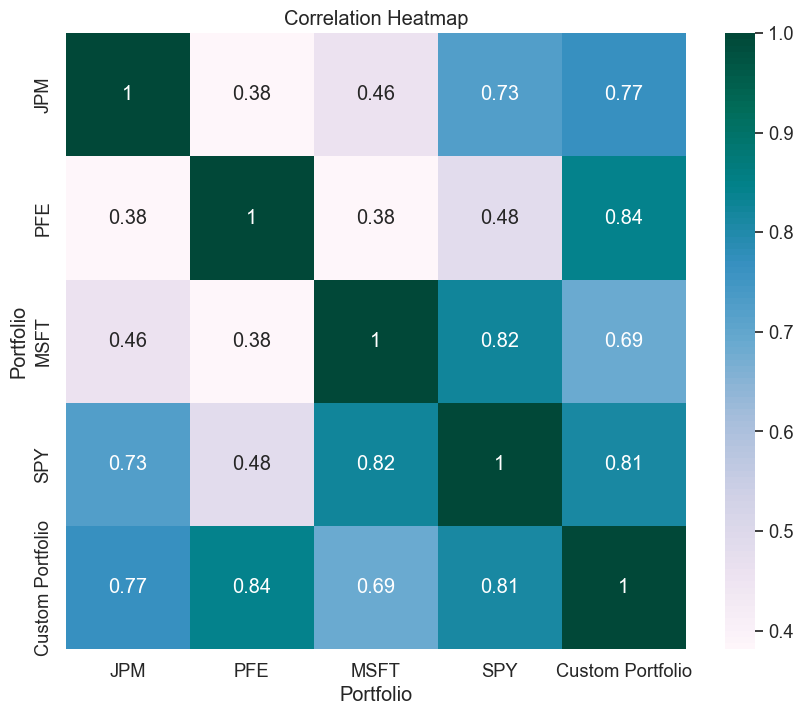

In [31]:
# Plot correlation matrix using heatmap
colors = sns.color_palette("PuBuGn", n_colors=100)

sns.set(font_scale=1.2)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap=colors)
plt.title("Correlation Heatmap")
plt.xlabel('Portfolio')
plt.ylabel('Portfolio')

# Show the plot
plt.show()

In [33]:
# Calculate beta
covariance_matrix = daily_returns.cov()

# JPM_beta = covariance_matrix.loc['JPM_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
# JNJ_beta = covariance_matrix.loc['JNJ_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
# MSFT_beta = covariance_matrix.loc['MSFT_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
# RIO_beta = covariance_matrix.loc['RIO_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
# PFE_beta = covariance_matrix.loc['PFE_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
stock1_beta = covariance_matrix.loc[stock_name1]['SPY'] / covariance_matrix.loc['SPY']['SPY']
stock2_beta = covariance_matrix.loc[stock_name2]['SPY'] / covariance_matrix.loc['SPY']['SPY']
stock3_beta = covariance_matrix.loc[stock_name3]['SPY'] / covariance_matrix.loc['SPY']['SPY']
portfolio_beta = covariance_matrix.loc['Custom Portfolio']['SPY'] / covariance_matrix.loc['SPY']['SPY']
spy_beta = covariance_matrix.loc['SPY']['SPY'] / covariance_matrix.loc['SPY']['SPY']

# print(f"JPM beta: {JPM_beta:.2f}")
# print(f"JNJ beta: {JNJ_beta:.2f}")
# print(f"MSFT beta: {MSFT_beta:.2f}")
# print(f"RIO beta: {RIO_beta:.2f}")
# print(f"PFE beta: {PFE_beta:.2f}")
print(f"{stock_name1} beta: {stock1_beta:.2f}")
if stock1_beta > spy_beta:
    print(f"{stock_name1} is more volatile than the overall market.")
elif stock1_beta < spy_beta:
    print(f"{stock_name1} is less volatile than the overall market.")
else:
    print(f"{stock_name1} has the same volatility as the overall market.")
print(f"{stock_name2} beta: {stock2_beta:.2f}")
if stock2_beta > spy_beta:
    print(f"{stock_name2} is more volatile than the overall market.")
elif stock2_beta < spy_beta:
    print(f"{stock_name2} is less volatile than the overall market.")
else:
    print(f"{stock_name2} has the same volatility as the overall market.")
print(f"{stock_name3} beta: {stock3_beta:.2f}")
if stock3_beta > spy_beta:
    print(f"{stock_name3} is more volatile than the overall market.")
elif stock3_beta < spy_beta:
    print(f"{stock_name3} is less volatile than the overall market.")
else:
    print(f"{stock_name3} has the same volatility as the overall market.")
print(f"Custom Portfolio beta: {portfolio_beta:.2f}")
if portfolio_beta > spy_beta:
    print(f"The custom portfolio is more volatile than the overall market.")
elif portfolio_beta < spy_beta:
    print(f"The custom portfolio is less volatile than the overall market.")
else:
    print(f"The custom portfolio has the same volatility as the overall market.")

JPM beta: 1.12
JPM is more volatile than the overall market.
PFE beta: 0.60
PFE is less volatile than the overall market.
MSFT beta: 1.22
MSFT is more volatile than the overall market.
Custom Portfolio beta: 0.88
The custom portfolio is less volatile than the overall market.


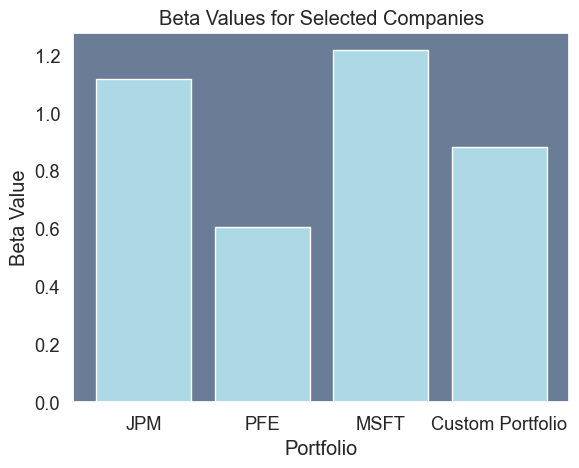

In [34]:
# Define beta values
beta_values = [stock1_beta,stock2_beta,stock3_beta,portfolio_beta]

# Define company names
company_names = [stock_name1, stock_name2, stock_name3, 'Custom Portfolio']

# Show the plot
colors = ['#ADD8E6']
plt.bar(company_names, beta_values, color=colors)
plt.title('Beta Values for Selected Companies')
plt.xlabel('Portfolio')
plt.ylabel('Beta Value')
plt.gca().set_facecolor('#6B7C96')
plt.grid(False)
plt.show()

In [40]:
# Sharpe Ratio
sharpe_ratio = (daily_returns.mean() * 252)/ (daily_returns.std() * np.sqrt(252))
sharpe_ratio.to_string()

'JPM                 0.299449\nPFE                 0.205278\nMSFT                0.912290\nSPY                 0.520691\nCustom Portfolio    0.492893'

In [53]:
# Set up OpenAI API key
openai.api_key = os.getenv("OPENAI_API_key")
# Convert the Sharpe ratio output to a string
sharpe_ratio_str = sharpe_ratio.to_string()

# Generate a summary using GPT-3
prompt = f"Please write a simple conclusion of the custom portfolio based on its Sharpe ratio. Provide a brief summary. \n\n{sharpe_ratio_str}"
response = openai.Completion.create(
    engine="text-davinci-002",
    prompt=prompt,
    max_tokens=100,
    n=1,
    stop=None,
    temperature=0.5,
)

# Print the summary generated by GPT-3
print(response.choices[0].text.strip())

The custom portfolio has a Sharpe ratio of 0.492893. This means that it outperforms the market by a small margin.


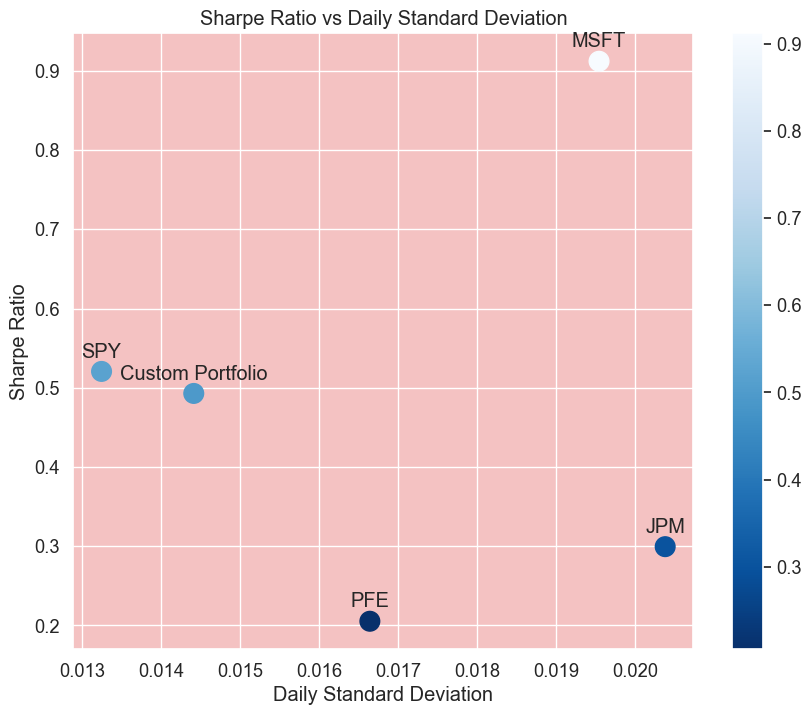

In [54]:
# Visualize the sharpe ratio vs Daily Standard Deviation
tickers = [stock_name1, stock_name2, stock_name3, 'SPY', 'Custom Portfolio']
sharpe_ratios = [sharpe_ratio[0], sharpe_ratio[1], sharpe_ratio[2], sharpe_ratio[3], sharpe_ratio[4]]
daily_std = [stock1_std, stock2_std, stock3_std, spy_stock, portfolio_std]
# Scatter plot with Sharpe ratios as color chart
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(daily_std, sharpe_ratios, c=sharpe_ratios, cmap='Blues_r', s=200)
ax.set_xlabel('Daily Standard Deviation')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio vs Daily Standard Deviation')
ax.set_facecolor('#F4C2C2')
# Add color bar
cbar = fig.colorbar(scatter)
cbar.set_label
# Add ticker labels to points
for i, ticker in enumerate(tickers):
    ax.annotate(ticker, (daily_std[i], sharpe_ratios[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

In [55]:
df_stock_combined = pd.concat([stock1,stock2,stock3], axis=1, keys=[stock_name1,stock_name2,stock_name3])

In [56]:
MC_ten_year = MCSimulation(
    portfolio_data = df_stock_combined,
    weights = weights,
    num_simulation = 500,
    num_trading_days = 252 * 10
)
MC_ten_year.portfolio_data.head()

JPM                                    \
                             open    high     low   close    volume   
timestamp                                                             
2018-05-07 04:00:00+00:00  108.76  109.68  108.36  109.37   9360321   
2018-05-08 04:00:00+00:00  109.53  111.34  109.28  110.99  12543451   
2018-05-09 04:00:00+00:00  111.44  113.64  111.03  113.41  11368094   
2018-05-10 04:00:00+00:00  113.19  114.44  112.75  114.29   9159723   
2018-05-11 04:00:00+00:00  114.49  114.73  113.67  113.86  10253045   

                                                                  PFE          \
                          trade_count        vwap daily_return   open    high   
timestamp                                                                       
2018-05-07 04:00:00+00:00       63644  109.112860          NaN  34.79  35.130   
2018-05-08 04:00:00+00:00       82974  110.634988     0.014812  34.91  35.090   
2018-05-09 04:00:00+00:00       77404  112.738976     0.021804  35.02  35.405   
2018-05-10 04:00:00+00:00       64923  113.926070     0.007759  35.00  35.310   
2018-05-11 04:00:00+00:00       66275  114.032989    -0.003762  35.13  35.560   

                           ...                             MSFT         \
                           ...       vwap daily_return     open   high   
timestamp                  ...                                           
2018-05-07 04:00:00+00:00  ...  34.961452          NaN  95.1700  96.71   
2018-05-08 04:00:00+00:00  ...  34.958877     0.001431  95.8456  96.16   
2018-05-09 04:00:00+00:00  ...  35.122553     0.005432  96.0100  96.97   
2018-05-10 04:00:00+00:00  ...  35.050560    -0.003696  97.3800  97.95   
2018-05-11 04:00:00+00:00  ...  35.409958     0.013128  97.8000  97.87   

                                                                            \
                               low  close    volume trade_count       vwap   
timestamp                                                                    
2018-05-07 04:00:00+00:00  95.1000  96.22  24262669      172194  96.187561   
2018-05-08 04:00:00+00:00  95.0631  95.81  23484705      158816  95.643806   
2018-05-09 04:00:00+00:00  95.0500  96.94  27327610      159050  96.349569   
2018-05-10 04:00:00+00:00  97.0500  97.91  22388119      130886  97.637509   
2018-05-11 04:00:00+00:00  97.0400  97.70  16778316      110233  97.508981   

                                        
                          daily_return  
timestamp                               
2018-05-07 04:00:00+00:00          NaN  
2018-05-08 04:00:00+00:00    -0.004261  
2018-05-09 04:00:00+00:00     0.011794  
2018-05-10 04:00:00+00:00     0.010006  
2018-05-11 04:00:00+00:00    -0.002145  

[5 rows x 24 columns]

In [57]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\boris\finTech\project_1\Project_1\code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000080,0.991749,0.990791,1.008972,0.991684,0.990693,1.026876,1.013125,1.005765,1.005718,...,1.015447,0.990025,0.991223,1.000407,0.986779,1.001859,0.993742,1.003232,1.000290,0.996002
2,0.997666,0.987832,0.981470,1.013307,0.988647,1.001903,1.033529,1.000763,1.017163,1.024791,...,1.019996,0.994823,1.003752,1.014818,0.987717,1.021991,0.986309,1.003877,1.008403,0.997959
3,1.007757,1.006408,0.970339,1.028893,0.991308,0.994796,1.021214,1.003462,1.019292,1.039380,...,1.016237,0.983494,0.992511,1.008761,0.990121,1.037396,0.987511,0.996424,1.013765,1.010780
4,1.003416,1.005504,0.989001,1.031969,0.982312,0.990866,1.022149,1.005375,1.036759,1.049083,...,1.019807,0.981264,0.994137,1.016399,1.011751,1.042967,0.966592,0.994235,0.998096,0.997045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.144122,3.058105,1.254669,3.139501,1.928356,2.024566,2.348055,3.984716,5.084077,4.290951,...,2.023033,2.405848,3.297311,5.008372,3.718753,3.352582,3.825707,4.280708,3.020079,1.054857
2517,1.138770,3.059296,1.244535,3.138323,1.912062,2.047292,2.376430,4.019907,5.134557,4.296908,...,2.031221,2.406863,3.263860,5.020918,3.745552,3.354357,3.824511,4.329163,2.983443,1.087253
2518,1.147875,3.115278,1.268003,3.154711,1.911917,2.032200,2.413378,4.012556,5.115322,4.380840,...,2.037628,2.407972,3.259829,5.047610,3.746278,3.392208,3.740851,4.316386,2.919243,1.090826
2519,1.135994,3.113401,1.281055,3.125929,1.900662,2.038342,2.378394,3.973450,5.092224,4.395955,...,2.046342,2.411656,3.233126,5.009244,3.761230,3.393386,3.744378,4.302900,2.880084,1.098856


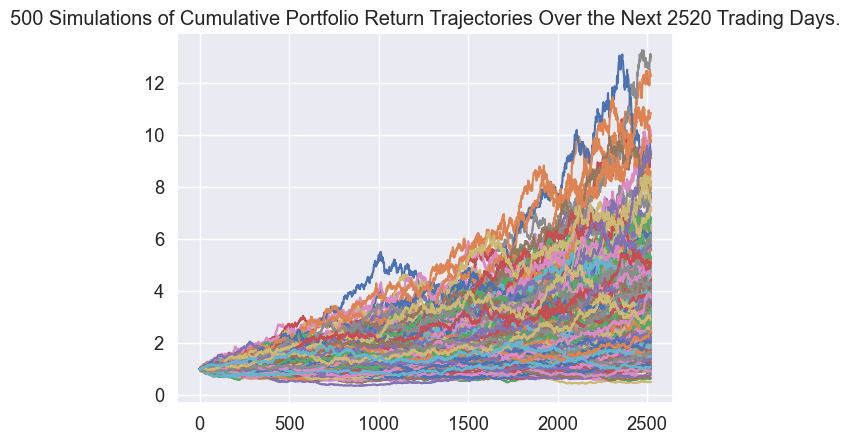

In [58]:
line_plot_five = MC_ten_year.plot_simulation()

In [59]:
simulated_returns_data = {
    "mean": list(MC_ten_year.simulated_return.mean(axis=1)),
    "median": list(MC_ten_year.simulated_return.median(axis=1)),
    "min": list(MC_ten_year.simulated_return.min(axis=1)),
    "max": list(MC_ten_year.simulated_return.max(axis=1))
}
# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
df_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.000725,1.000414,0.973423,1.032974
2,1.000016,0.999593,0.961200,1.041624
3,1.000280,1.001383,0.944304,1.064207
4,1.000847,0.999175,0.934884,1.086216


In [61]:
# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl = initial_investment * df_simulated_returns
cumulative_pnl

,mean,median,min,max
0,10000.000000,10000.000000,10000.000000,10000.000000
1,10007.254968,10004.135891,9734.225307,10329.740115
2,10000.160978,9995.926434,9612.001101,10416.240520
3,10002.795648,10013.831537,9443.036938,10642.070932
4,10008.468511,9991.754756,9348.838264,10862.159201
...,...,...,...,...
2516,31351.052301,27369.938147,5041.485187,130723.458176
2517,31392.975002,27369.327530,5048.834980,128406.114428
2518,31405.150087,27271.144210,5081.579103,129990.922321
2519,31405.425112,27310.576234,4979.175611,131019.059577


In [62]:
 # Fetch summary statistics from the Monte Carlo simulation results
# Hint: Use the `summarize_cumulative_return` function
tbl = MC_ten_year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              3.144340
std               1.843905
min               0.506142
25%               1.852621
50%               2.722832
75%               3.967406
max              12.974575
95% CI Lower      0.944581
95% CI Upper      8.076357
Name: 2520, dtype: float64


In [66]:
 # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in TSLA stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next year will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next year will end within in the range of $9445.81 and $80763.57.


In [67]:
# Define the prompt to be used to generate the board information
prompt = f"Seperate List of Board members of {stock_name1}, {stock_name2} and {stock_name3}"

# Specify the language model to be used for the request
model = "text-davinci-002"

# Generate the board information using the OpenAI API
response = openai.Completion.create(
    engine=model,
    prompt=prompt,
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

# Extract the generated text from the API response
board_info = response.choices[0].text.strip()
# Split the string into three paragraphs
paragraphs = board_info.split('\n\n\n')

# Print each paragraph
for i, paragraph in enumerate(paragraphs):
    print("List of Board members of the 3 companies you picked:")
    print(paragraph)
    print()

List of Board members of the 3 companies you picked:
JPM

1. William C. Dudley
2. Mary Callahan Erdoes
3. Michael J. Cavanagh
4. James A. Bell
5. Ellen F. Kullman
6. Laban P. Jackson, Jr.
7. Jaime Dimon
8. Stephen B. Burke
9. James S. Crown
10. Timothy P. Flynn
11. Jennifer A. Johnson
12. Douglas A. Warner III
13. Ronald O'Hanley

PFE

1. Albert Bourla
2. Charles O. Holliday, Jr.
3. Lamberto Andreotti
4. Sally Blount
5. Dawn Hudson
6. Ian Read
7. Mikael Dolsten
8. Tracy Dolan
9. Bourla

MSFT

1. Satya Nadella
2. John W. Thompson
3. Reid Hoffman
4. Teri L. List-Stoll
5. Hugh Johnston
6. Sandra E. Peterson
7. Charles H. Noski
8. G. Mason Morfit
9. Reid Garrett Hoffman
10. Amy Hood

